## Comparability across space and time with OT

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
from scipy.stats import spearmanr
import json
from scipy.stats import norm
from sklearn.metrics import mean_absolute_percentage_error

from scipy.spatial.distance import cdist
import wasserstein

from geoemd.loss.partial_ot import PartialOT

from datetime import datetime
from collections import defaultdict
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
plt.rcParams.update({"font.size":15})

from geoemd.utils import space_cost_matrix, spacetime_cost_matrix
import ot
from geoemd.utils import spacetime_cost_matrix
from geoemd.loss.partial_ot import PartialOT

appl_name_mapping = {"charging": "Charging station occupancy", "traffic": "Traffic flow", "bikes": "Bike sharing demand", "carsharing": "Car sharing demand"}

def compute_pot(cost_matrix, pred_vals, real_vals, phi=0):
    ot_obj = PartialOT(cost_matrix, compute_exact=True, normalize_c=False, penalty_unb=phi)
    return ot_obj( torch.from_numpy(pred_vals).unsqueeze(0),
                   torch.from_numpy(real_vals).unsqueeze(0))



### Compare different ways to compare across scale

In [2]:
mode_mapping = {"sts": "Station-to-station", "gtg": "Group-to-group", "gts": "Group-to-station"}
cluster_mapping = {"kmeans": "KMeans", "agg": "Agglomerative", "quartierhabitation": "Districts (housing)", "quartiersociologic": "Districts (sociological)"}
xlabel = "Number of clusters"

def get_num_clusters(x):
    # helper function to get number of clusters from the file name
    if x[-4:] == "None":
        return 458 # NOTE: Only works for bike sharing
    else:
        return int(x.split("_")[-2])

plt.rcParams.update({"font.size": 12})

---------- Group-to-group MSE ---------


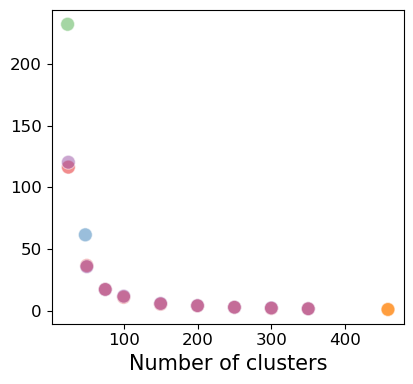

---------- Station-to-station MSE ---------


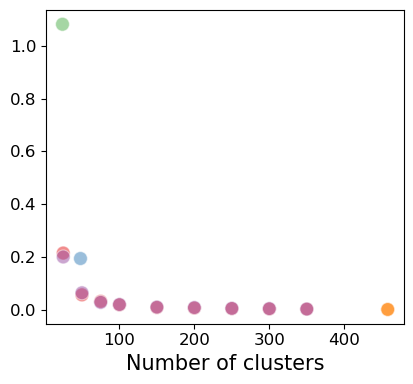

---------- Group-to-group station-wise MSE ---------


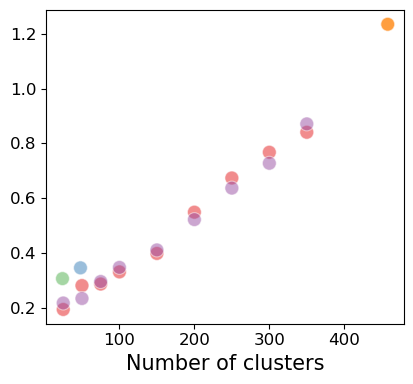

---------- Group-to-group unb_ot_quantile_1 ---------


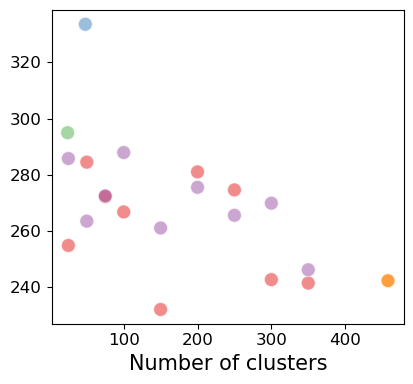

---------- Group-to-station unb_ot_quantile_1 ---------


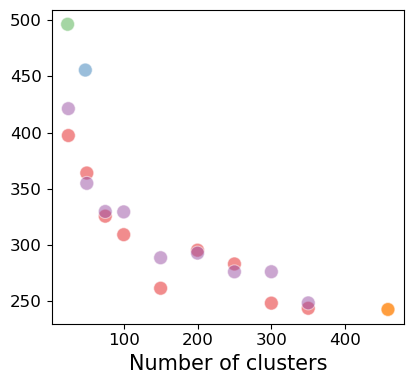

---------- Station-to-station unb_ot_quantile_1 ---------


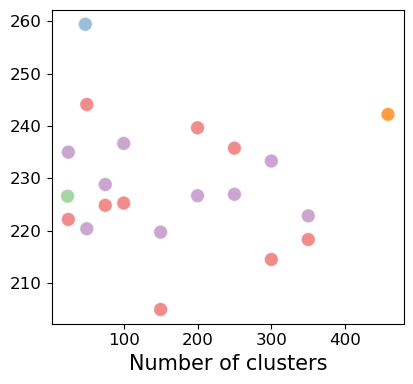

In [13]:
for ylabel, mode in zip(["MSE", "MSE", "station-wise MSE", "unb_ot_quantile_1", "unb_ot_quantile_1", "unb_ot_quantile_1"], ["gtg", "sts", "gtg", "gtg", "gts", "sts"]): # , 'unb_ot_quantile_10']: # kind of interesting pattern
    results = pd.read_csv(os.path.join("..", "data_submission", "scale_results", f"bikes_{mode}.csv"))
    print(f"---------- {mode_mapping[mode]} {ylabel} ---------")
    if ylabel not in results.columns:
        continue
    results[xlabel] = results["name"].apply(get_num_clusters)
    results["Clustering"] = results["clustering"].map(cluster_mapping)
    results = results[results["nr_group"] > 10] # excluded 10
    results.loc[results["nr_group"] == 458, "Clustering"] = "Not clustered"
    results.sort_values("Clustering", inplace=True)
    if any(results[ylabel] > 1000):
        results[ylabel] = results[ylabel] / 1000
    fig, ax = plt.subplots(figsize=(4.3,4))
    sns.scatterplot(data=results, x=xlabel, y=ylabel, hue="Clustering", marker="o", s=100, alpha=0.5, palette="Set1"
)
    plt.xlabel(xlabel, fontsize=15)        
    plt.legend([],[], frameon=False)
    plt.ylabel("")
    if ylabel == "MSE":
        save_label = "mse"
        # plt.ylabel("MSE", fontsize=15)
        plt.tight_layout()
        # plt.savefig(f"figures/scale_mse_normed.png")
    elif ylabel == "station-wise MSE":
        save_label = "mse_normed"
        # plt.ylabel("Normalized MSE", fontsize=15)
        plt.tight_layout()
    else:
        save_label = "ot"
        # plt.ylabel(r"Partial OT error", fontsize=15)
        plt.tight_layout()
    plt.savefig(f"../figures_revision/scale_{save_label}_{mode}.png")
    plt.show()

### Compare across time 

In [4]:
import torch
from geoemd.utils import space_cost_matrix, spacetime_cost_matrix

In [18]:
stations = pd.read_csv(os.path.join("..", "data_submission", "data_raw", "bikes_stations.csv")).set_index("station_id")

In [6]:
dist_matrix = cdist(stations[["x", "y"]].values, stations[["x", "y"]].values) / 1000
time_matrix = space_cost_matrix(stations, speed_factor=5) # 5km/h walking speed

# create cost matrix with costs across space and time
spacetime_matrix = spacetime_cost_matrix(time_matrix,
                    time_steps=5,
                    forward_cost=1,
                    backward_cost=1
                                        )

In [7]:
res_dict_list = []
ot_spacetime = PartialOT(spacetime_matrix, compute_exact=True, normalize_c=False, penalty_unb=0)
ot_space = PartialOT(dist_matrix, compute_exact=True, normalize_c=False, penalty_unb=0)

issues_wasserstein = 0
for path, name in zip([
    os.path.join("..", "data_submission", "predictions", "predictions_bike_sharing_linear.csv"),
    os.path.join("..", "data_submission", "predictions", "predictions_bike_sharing_nhits.csv"),
], ["linear regression", "N-HiTS"]):
    res = pd.read_csv(path)

    for sample, sample_df in res.groupby("val_sample_ind"):
        # first, pivot to bring it to the same shape as in our previous experiments
        pred_arr = np.expand_dims(sample_df.pivot(columns=["steps_ahead"], index=["group"], values="pred").values.swapaxes(1,0), 0)
        gt_arr = np.expand_dims(sample_df.pivot(columns=["steps_ahead"], index=["group"], values="gt").values.swapaxes(1,0), 0)
        
        # make spacetime prediction by flattening
        pred = pred_arr.reshape((1, -1))
        gt = gt_arr.reshape((1, -1))
        
        try:
            eot_spacetime = ot_spacetime( torch.from_numpy(pred), torch.from_numpy(gt))
        except:
            issues_wasserstein += 1
            continue
    
        single_step_eot = []
        for timestep in range(pred_arr.shape[1]):
            pred_timestep = pred_arr[0, timestep]
            gt_timestep = gt_arr[0, timestep]
            e_ot = ot_space(torch.from_numpy(pred_timestep).unsqueeze(0), torch.from_numpy(gt_timestep).unsqueeze(0))
            single_step_eot.append(e_ot)
        eot_space = np.mean(single_step_eot)

        res_dict = {"model": name, "sample": sample, "mean spatial $E_{OT}$": eot_space, "spatiotemporal $E_{OT}$": eot_spacetime, "MSE": np.mean((pred_arr - gt_arr)**2),
                   "MSE step-wise": np.mean((pred_arr - gt_arr)**2, axis=2)}
        res_dict_list.append(res_dict)

print(f"Finished processing, processed {len(res_dict_list)}, {issues_wasserstein} failed because of numerical issues with Wasserstein distance")

Finished processing, processed 196, 4 failed because of numerical issues with Wasserstein distance


In [8]:
res_dict_list = pd.DataFrame(res_dict_list)

In [9]:
latex_table = res_dict_list.groupby("model").agg({col: "mean" for col in res_dict_list.columns if col not in ["model", "sample"]})

In [10]:
print(latex_table.drop("MSE step-wise", axis=1).round(2).astype(str).swapaxes(1,0).to_latex())

\begin{tabular}{lll}
\toprule
model & N-HiTS & linear regression \\
\midrule
mean spatial $E_{OT}$ & 39.05 & 46.07 \\
spatiotemporal $E_{OT}$ & 52.14 & 67.62 \\
MSE & 1.23 & 1.94 \\
\bottomrule
\end{tabular}



#### Compute how much N-HiTS improves over linear regression

In [12]:
for col in latex_table.columns:
    if "step" in col:
        continue
    lin = latex_table.loc["linear regression", col]
    nhits = latex_table.loc["N-HiTS", col]
    print(col, round((lin - nhits) / nhits * 100, 2), "%") 

mean spatial $E_{OT}$ 17.97 %
spatiotemporal $E_{OT}$ 29.68 %
MSE 57.16 %
